In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

hardware_name = "L4"

layernorm_gpu_run = pd.read_csv(
    f"../results/layernorm_{hardware_name}_gpu.csv", header=None, names=["M", "N", "latency", "throughput", "power", "energy", "frequency", ""]
)
layernorm_gpu_run["throughput"] = (
    layernorm_gpu_run["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
layernorm_gpu_run["latency"] = (
    layernorm_gpu_run["latency"].str.extract(r"(\d+\.?\d*)").astype(float)
)
layernorm_gpu_run.set_index(["M", "N"], inplace=True)

layernorm_gpu_sim = pd.read_csv(
    f"../results/layernorm_{hardware_name}_sim.csv", header=None, names=["M", "N", "latency", "throughput", "power", "total", "memory_to_l2_transfer", "l2_to_l1_transfer", "l1_to_l0_transfer", "compute"]
)
layernorm_gpu_sim["throughput"] = (
    layernorm_gpu_sim["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
layernorm_gpu_sim["latency"] = (
    layernorm_gpu_sim["latency"].str.extract(r"(\d+\.?\d*)").astype(float)
)
layernorm_gpu_sim.set_index(["M", "N"], inplace=True)

color_NV = sns.color_palette("Greens_d", 4)[1:]

In [16]:
M = 2**12
N = 2**5
layernorm_gpu_run.sort_index(inplace=True)
layernorm_gpu_sim.sort_index(inplace=True)
layernorm_gpu_run.loc[(M, N), "throughput"].values[0]

np.float64(1.8448)

In [17]:
sim_frequency = {
    "L4": 2040,
    "RTX6000Ada": 2505,
    "RTX4090": 2520,
}

[[np.int64(79691776), np.int64(159383552), np.int64(318767104), np.int64(637534208), np.int64(1275068416), np.int64(2550136832), np.int64(5100273664), np.int64(10200547328), np.int64(20401094656), np.int64(40802189312), np.int64(81604378624), np.int64(163208757248), np.int64(326417514496), np.int64(652835028992), np.int64(1305670057984)], [np.float64(21286092.8), np.float64(42572185.6), np.float64(85144371.2), np.float64(170288742.4), np.float64(340577484.8), np.float64(681154969.6), np.float64(1362309939.2), np.float64(2724619878.4), np.float64(5449239756.8), np.float64(10898479513.6), np.float64(21796959027.2), np.float64(43593918054.4), np.float64(87187836108.8), np.float64(174375672217.6), np.float64(348751344435.2)], [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)], [np.float64(734003.2000000001), np.float64(1468006.4), np.float64(29360

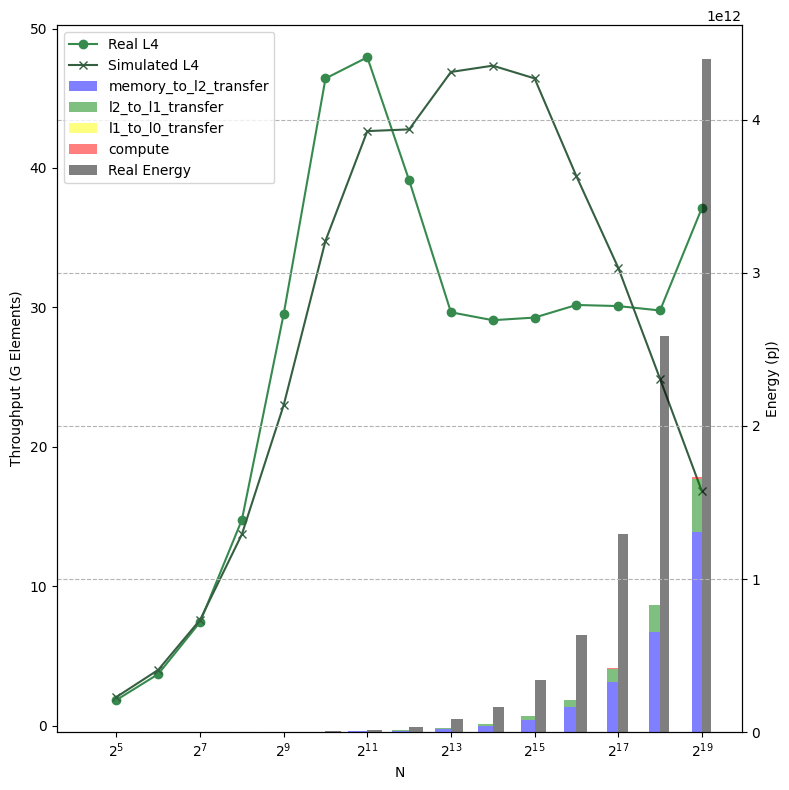

In [29]:
M = 2**12
title = f"Performance of Softmax with M={M}"
N_list = []

throughput_GPU_run_list = []
energy_GPU_run_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for N in range(5, 20):
    N = 2**N
    N_list.append(N)
    throughput_GPU_run_list.append(layernorm_gpu_run.loc[(M, N), "throughput"].values[0])
    energy_GPU_run_list.append(layernorm_gpu_run.loc[(M, N), "energy"].values[0])
    throughput_GPU_sim_list.append(layernorm_gpu_sim.loc[(M, N), "throughput"].values[0] / sim_frequency[hardware_name] * layernorm_gpu_run.loc[(M, N), "frequency"].values[0])
    energy_GPU_sim_list[0].append(layernorm_gpu_sim.loc[(M, N), "memory_to_l2_transfer"].values[0])
    energy_GPU_sim_list[1].append(layernorm_gpu_sim.loc[(M, N), "l2_to_l1_transfer"].values[0])
    energy_GPU_sim_list[2].append(layernorm_gpu_sim.loc[(M, N), "l1_to_l0_transfer"].values[0])
    energy_GPU_sim_list[3].append(layernorm_gpu_sim.loc[(M, N), "compute"].values[0])

print(energy_GPU_sim_list)

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("N")
ax1.plot(N_list, throughput_GPU_run_list, marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax1.plot(N_list, throughput_GPU_sim_list, marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])
ax1.set_ylabel('Throughput (G Elements)')

ax2 = ax1.twinx()
N_list = np.array(N_list)
bar_widths = ((N_list - 2**4) * 3) / np.log2(N_list - 2**4)
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax2.bar(N_list + (bar_widths / 2), energy_GPU_run_list, width = bar_widths, label='Real Energy', color='black', alpha=0.5)

ax2.plot([], [], marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax2.plot([], [], marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])

ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()


[[np.int64(79691776), np.int64(159383552), np.int64(318767104), np.int64(637534208), np.int64(1275068416), np.int64(2550136832), np.int64(5100273664), np.int64(10200547328), np.int64(20401094656), np.int64(40802189312), np.int64(81604378624), np.int64(163208757248), np.int64(326417514496), np.int64(652835028992), np.int64(1305670057984)], [np.float64(21286092.8), np.float64(42572185.6), np.float64(85144371.2), np.float64(170288742.4), np.float64(340577484.8), np.float64(681154969.6), np.float64(1362309939.2), np.float64(2724619878.4), np.float64(5449239756.8), np.float64(10898479513.6), np.float64(21796959027.2), np.float64(43593918054.4), np.float64(87187836108.8), np.float64(174375672217.6), np.float64(348751344435.2)], [np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)], [np.float64(734003.2000000001), np.float64(1468006.4), np.float64(29360

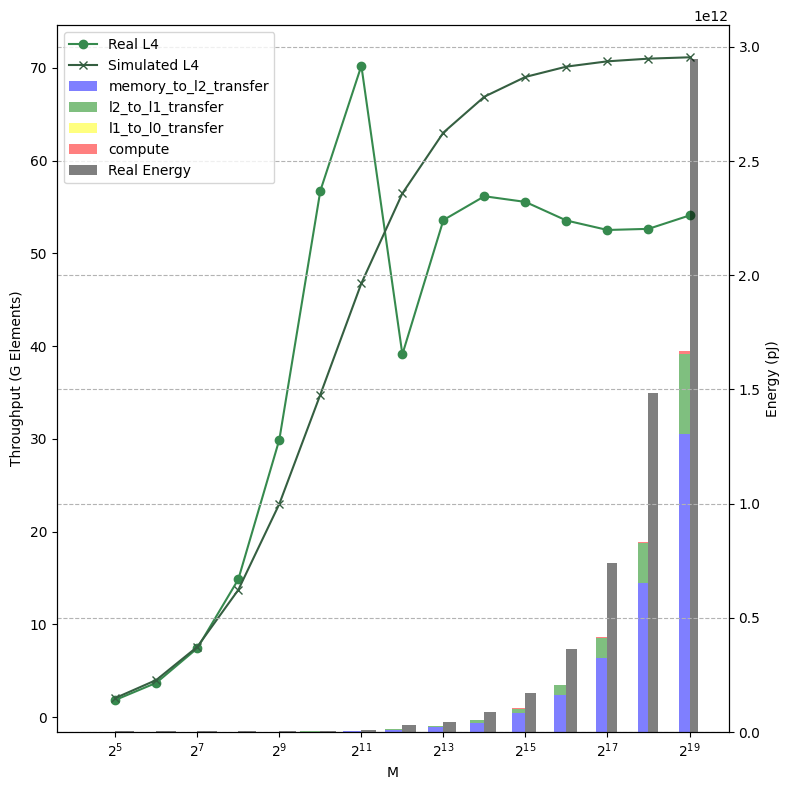

In [27]:
N= 2**12
title = f"Performance of Softmax with M={M}"
N_list = []

throughput_GPU_run_list = []
energy_GPU_run_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for M in range(5, 20):
    M = 2**M
    N_list.append(M)
    throughput_GPU_run_list.append(layernorm_gpu_run.loc[(M, N), "throughput"].iloc[0])
    energy_GPU_run_list.append(layernorm_gpu_run.loc[(M, N), "energy"].iloc[0])
    throughput_GPU_sim_list.append(layernorm_gpu_sim.loc[(M, N), "throughput"].iloc[0])
    energy_GPU_sim_list[0].append(layernorm_gpu_sim.loc[(M, N), "memory_to_l2_transfer"].iloc[0])
    energy_GPU_sim_list[1].append(layernorm_gpu_sim.loc[(M, N), "l2_to_l1_transfer"].iloc[0])
    energy_GPU_sim_list[2].append(layernorm_gpu_sim.loc[(M, N), "l1_to_l0_transfer"].iloc[0])
    energy_GPU_sim_list[3].append(layernorm_gpu_sim.loc[(M, N), "compute"].iloc[0])

print(energy_GPU_sim_list)

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("M")
ax1.plot(N_list, throughput_GPU_run_list, marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax1.plot(N_list, throughput_GPU_sim_list, marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])
ax1.set_ylabel('Throughput (G Elements)')

ax2 = ax1.twinx()
N_list = np.array(N_list)
bar_widths = ((N_list - 2**4) * 3) / np.log2(N_list - 2**4)
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(N_list - (bar_widths / 2), energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax2.bar(N_list + (bar_widths / 2), energy_GPU_run_list, width = bar_widths, label='Real Energy', color='black', alpha=0.5)

ax2.plot([], [], marker="o", label=f"Real {hardware_name}", color=color_NV[1])
ax2.plot([], [], marker="x", label=f"Simulated {hardware_name}", color=color_NV[2])

ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()